# Intro to Machine Learning: Supervised Learning
### Titanic ML models analysis
This is the project with the objective to predict if a Titatnic passenger survied. This is a Kaggle dataset used for the competition to see who can build a good predictor for the problem.

#### Libraries to Import

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#sklean libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

#### Data Sourcing and EDA

First I'm going to read the CSV from the data set I'm focusing on to make them usable in this notebook. After we verify the data is all set up I'm going to do some EDA to see what we might need to modify in order to run it through the models and predict the **Survived** column.

In [160]:
# Upload Data
test_result = pd.read_csv('./data/gender_submission.csv')
test_features = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')
test = pd.merge(test_features,test_result, on='PassengerId')

In [161]:
# EDA
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [162]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [163]:
missing_info = train.isna().sum()
missing_info_percent = missing_info/train.shape[0] * 100
print(missing_info, missing_info_percent)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


From this first overview we can see that the dataset has both numeric and categorical fields.
* Numeric: age, sibsp, parch, fare
* Categorical: pcalss, sex, embarked
* Other features: name, ticket, cabin, passengerid

The reason I'm point out ther are other features is because we might be able to drop these from the features because of the following reasons:
* Names: This is irrelevant data that brings no value to the objective of the model, this might add noise and every single value is different.
* Ticket: Similar to the name every ticket number might be able to help but the possibility is really low, we might need to deep dive on the ticket numbers to attain some context on what does the numbers and letters mean in the ticket feature.
* Cabin: Derived from our EDA we see that **77%** of the data is missing so I've decided to get rid of this feature
* PassengerID: this one was basically used to identify each passenger but for this case we do not need that information since we want random samples and we've been provided a train and test sets.

In [164]:
#Impute missing Values of Age with median looking at the histogram
train['Age'].fillna(train['Age'].median(), inplace=True)

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

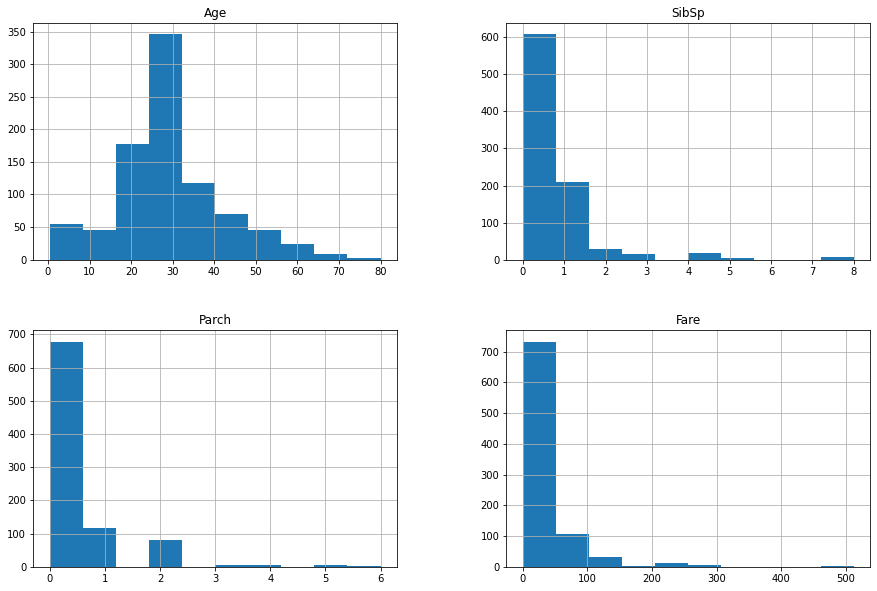

In [165]:
# Numeric Feature EDA
numeric_feature = train[['Age', 'SibSp', 'Parch', 'Fare']]
numeric_feature.hist(figsize= (15, 10))

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

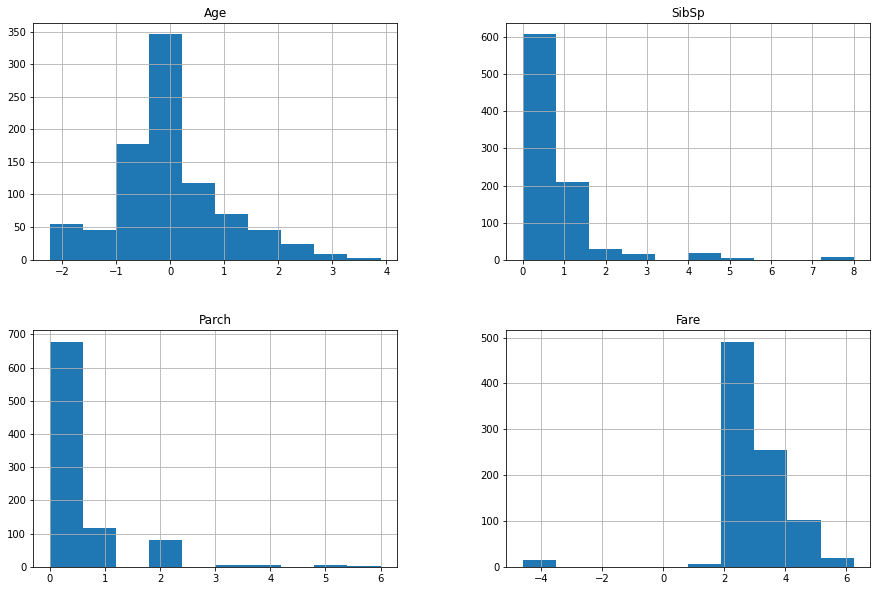

In [166]:
# Scaling 'Age' for the model
scaler = StandardScaler()
train['Age'] = scaler.fit_transform(train[['Age']]) 

# Removing skewness of the rest of the parameters
train['Fare'] = np.log(train['Fare'] + 0.01)

train[['Age', 'SibSp', 'Parch', 'Fare']].hist(figsize=(15,10))

In this case we see that both Parch and SibSp are quite difficult to scale and remove skewness due to this information and knowing that this values are `SibSp` Number of Siblings/Spouses aboard and `Parch` Number of Parents/Children which might create some correlation between the values we create a categorical feature to see if they boarded alone or not.

In [167]:
train['Alone'] = train['SibSp'] + train['Parch']

for index in range(len(train)):
    if train['Alone'][index] != 0:
        train['Alone'][index] = 0
    else:
        train['Alone'][index] = 1

C:\Users\ruben\AppData\Local\Temp\ipykernel_1244\947491048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Alone'][index] = 0
C:\Users\ruben\AppData\Local\Temp\ipykernel_1244\947491048.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Alone'][index] = 1


In [168]:
# Categoric Feature EDA
print('Values to impute:',train['Embarked'].isna().sum())
print(train['Embarked'].value_counts())

Values to impute: 2
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [169]:
train['Embarked'].fillna('S', inplace=True)

In [170]:
oneHot = OneHotEncoder(categories='auto', handle_unknown='ignore')
feature_array = oneHot.fit_transform(train[['Pclass', 'Sex', 'Embarked']]).toarray()

feature_labels = oneHot.categories_
feature_labels = list(np.concatenate(feature_labels).flat)

encoded_features = pd.DataFrame(feature_array, columns=feature_labels)

interestdf = train.merge(encoded_features, left_index=True, right_index=True)

In [172]:
features = [1, 2, 3, 'female', 'male', 'C', 'Q', 'S', 'Age', 'Fare', 'Alone']
X = interestdf[features]
y = interestdf['Survived']

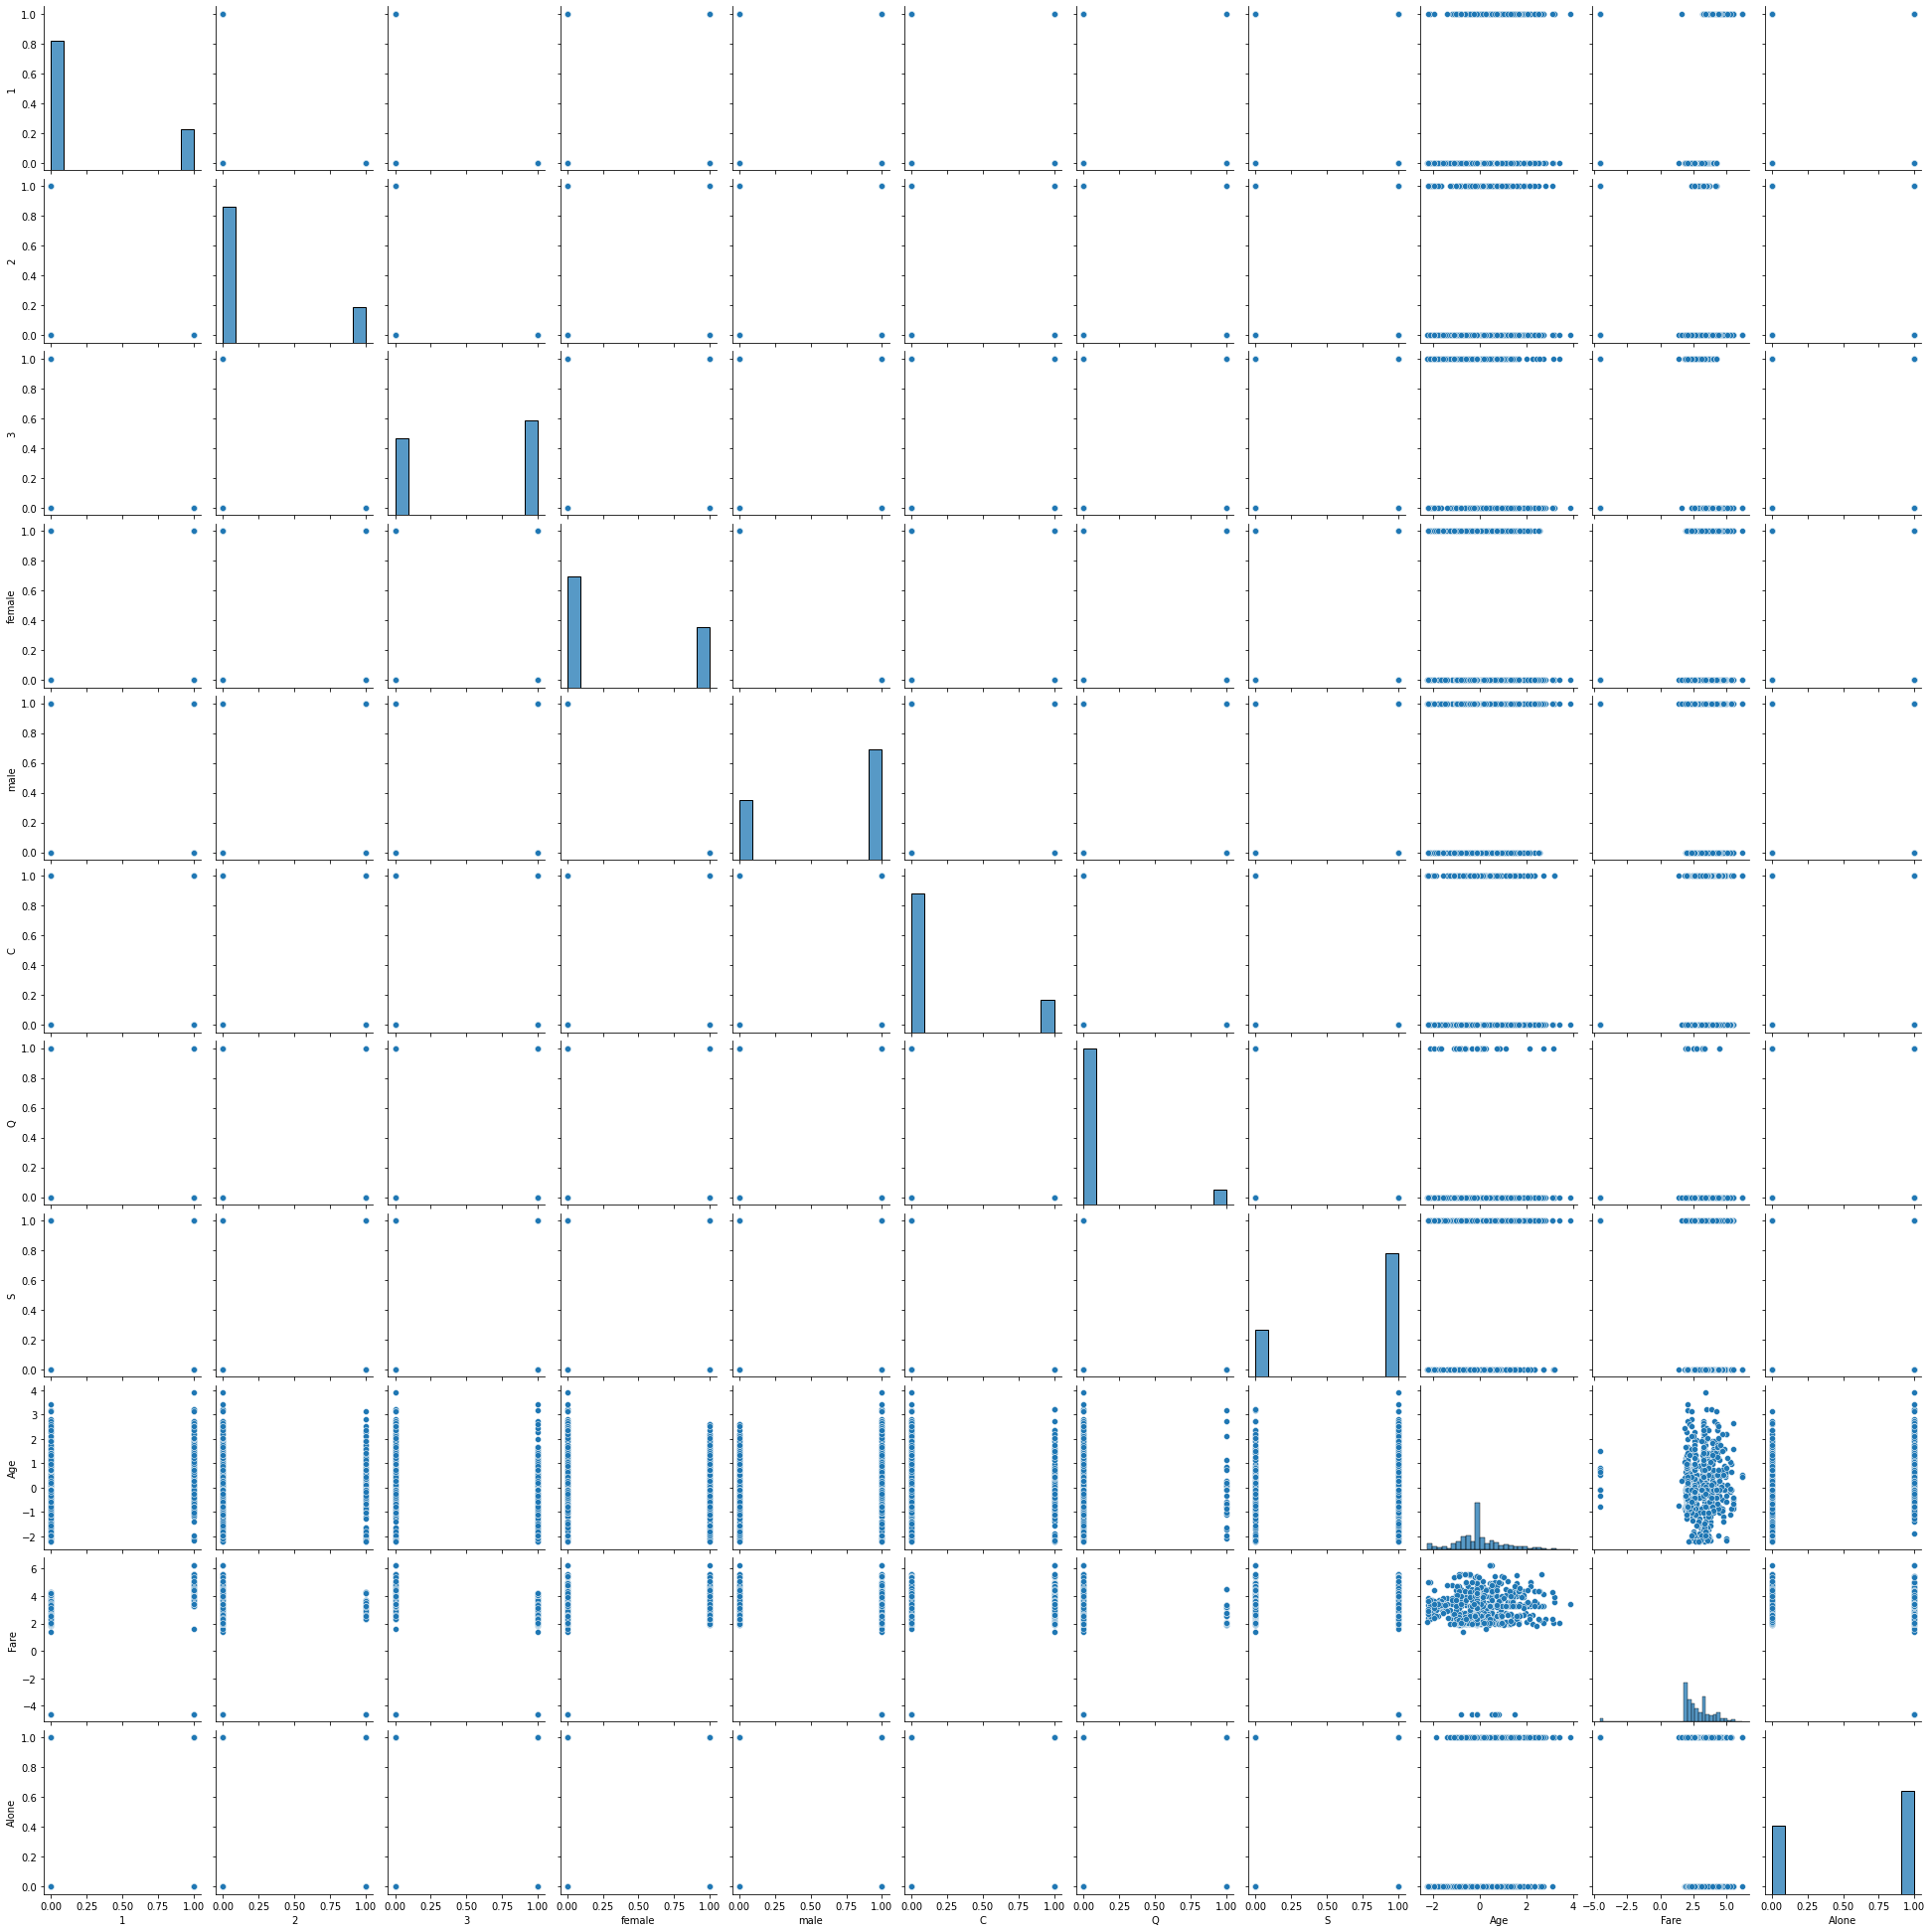

In [173]:
sns.pairplot(X)